# Colab

> Dev Notebook

In [1]:
# | hide
# | hide
%reload_ext autoreload
%reload_ext nb_black
%autoreload 2
from nbdev.showdoc import *
import sys

__root = "../"
sys.path.append(__root)

<IPython.core.display.Javascript object>

In [2]:
# | export
from torch_snippets import *
from diffusion.config import Config
from diffusion.models import *
from diffusion.dataset import *
from diffusion.infer import *

<IPython.core.display.Javascript object>

In [5]:
# | export
def construct_noise_schedules(config):
    c = config
    t = np.linspace(0, 1, c.timesteps + 1)
    b_t = (c.beta2 - c.beta1) * t + c.beta1
    a_t = 1 - b_t
    ab_t = np.ones(c.timesteps + 1)
    for i in range(1, c.timesteps + 1):
        ab_t[i] = np.exp(np.log(ab_t[i - 1]) + np.log(a_t[i]))
    b_t = (c.beta2 - c.beta1) * torch.linspace(
        0, 1, c.timesteps + 1, device=c.device
    ) + c.beta1
    a_t = 1 - b_t
    ab_t = torch.cumsum(a_t.log(), dim=0).exp()
    ab_t[0] = 1
    return ab_t, a_t, b_t

<IPython.core.display.Javascript object>

In [6]:
config = Config()
config.height = 16

ab_t, a_t, b_t = construct_noise_schedules(config)

nn_model = ContextUnet(
    in_channels=3, n_feat=config.n_feat, n_cfeat=config.n_cfeat, height=config.height
).to(device)

<IPython.core.display.Javascript object>

In [8]:
images_npy = "images.npy"
if not exists(images_npy):
    all_files = Glob("/mnt/347832F37832B388/ml-datasets/faces4/*/*/*")
    Info(f"{len(all_files)} images found")
    image_arrays = []
    for ix, file in enumerate(track2(all_files[:89000])):
        try:
            im = resize(read(file, 1), 64)
            image_arrays.append(im)
        except:
            continue
    images_np = np.array(image_arrays)
    np.save(images_npy, images_np)

<IPython.core.display.Javascript object>

In [13]:
batch_size = 100
dataset = CustomDataset("./images.npy")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=config.lrate)

[09/24/23 19:51:29] INFO     sprite shape: (89000, 64, 64, 3)                                                                                         ]8;id=217027;file:///mnt/347832F37832B388/projects/MCVP2e/Chapter-15b/Diffusion/nbs/../diffusion/dataset.py:43\dataset.py]8;;\:]8;id=381291;file:///mnt/347832F37832B388/projects/MCVP2e/Chapter-15b/Diffusion/nbs/../diffusion/dataset.py:43#__init__:43\__init__:43]8;;\

<IPython.core.display.Javascript object>

In [20]:
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

c = config
nn_model.train()

for ep in range(c.n_epoch):
    print(f'epoch {ep}')
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = c.lrate*(1-ep/c.n_epoch)
    for x in (tracker:=track2(dataloader)):   # x: images
        optim.zero_grad()
        x = x.to(device)
        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, c.timesteps + 1, (x.shape[0],)).to(device)
        x_pert = perturb_input(x, t, noise)
        # use network to recover noise
        pred_noise = nn_model(x_pert, t / c.timesteps)
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        tracker.send(f'Loss: {loss.item():.2f}')
        loss.backward()
        optim.step()


epoch 0

Traceback (most recent call last):
  File "/home/yyr/anaconda3/envs/mcvp-book/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/yyr/anaconda3/envs/mcvp-book/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/yyr/anaconda3/envs/mcvp-book/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/yyr/anaconda3/envs/mcvp-book/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Traceback (most recent call last):
  File "/home/yyr/anaconda3/envs/mcvp-book/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/yyr/anaconda3/envs/mcvp-book/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/yyr/anaconda3/envs/mcvp-book/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/yyr/anaconda3/envs/mcvp-book/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


epoch 1

epoch 2

epoch 3

epoch 4

epoch 5

epoch 6

epoch 7

epoch 8

epoch 9

epoch 10

epoch 11

epoch 12

epoch 13

epoch 14

epoch 15

epoch 16

epoch 17

epoch 18

epoch 19

epoch 20

epoch 21

epoch 22

epoch 23


KeyboardInterrupt



<IPython.core.display.Javascript object>

In [22]:
save_torch_model_weights_from(nn_model, "model.pth")

[09/24/23 22:34:46] INFO     Saved weights of size ~5 MB to model.pth                                                                               ]8;id=141097;file:///tmp/ipykernel_45084/3682354670.py:1\3682354670.py]8;;\:]8;id=942365;file:///tmp/ipykernel_45084/3682354670.py:1#<module>:1\<module>:1]8;;\

<IPython.core.display.Javascript object>

In [ ]:
config = Config()
config.height = 16

nn_model = ContextUnet(
    in_channels=3, n_feat=config.n_feat, n_cfeat=config.n_cfeat, height=config.height
).to(device)

load_torch_model_weights_to(nn_model, "model.pth")

In [5]:
samples, intermediate_ddpm = sample_ddpm(nn_model, 32, config)

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

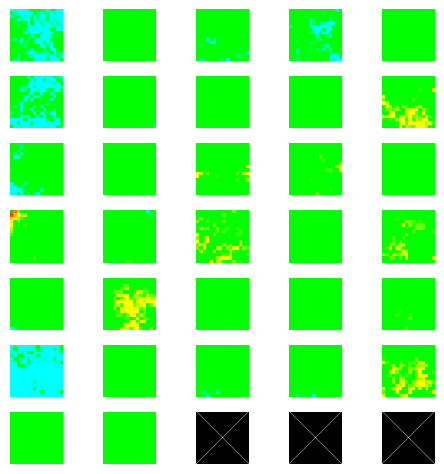

<IPython.core.display.Javascript object>

In [6]:
subplots(samples)

In [6]:
# | hide
import nbdev
nbdev.nbdev_export()

<IPython.core.display.Javascript object>